In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from src.models.upernet import UperNet
from src.losses import Criterion
from src.utils.io import load_image, load_mask

model = UperNet(freeze_backbone=False)

print(f"Number of parameters: {model.n_trainable_params / 1e6:.2f} M")

Number of parameters: 60.30 M


In [3]:
tens = torch.rand(2, 3, 400, 400)

out = model(tens)

out.shape

torch.Size([2, 400, 400])

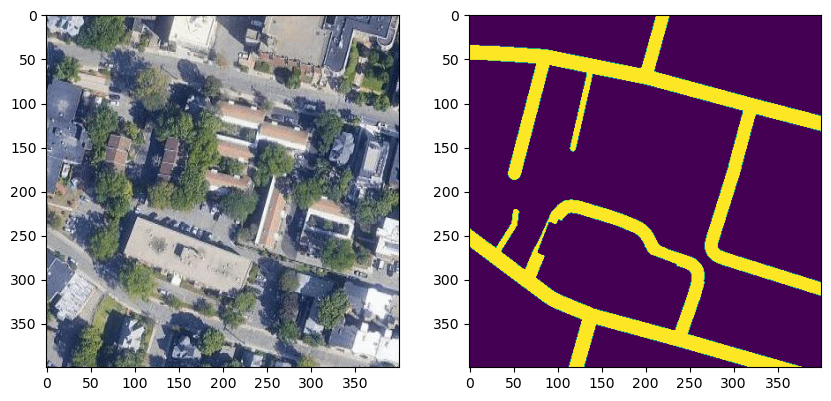

In [4]:
img = load_image("../data/processed/validation/images/000000001_cil.jpg") * 255
mask = load_mask("../data/processed/validation/masks/000000001_cil.png")

img = img.astype("uint8")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()

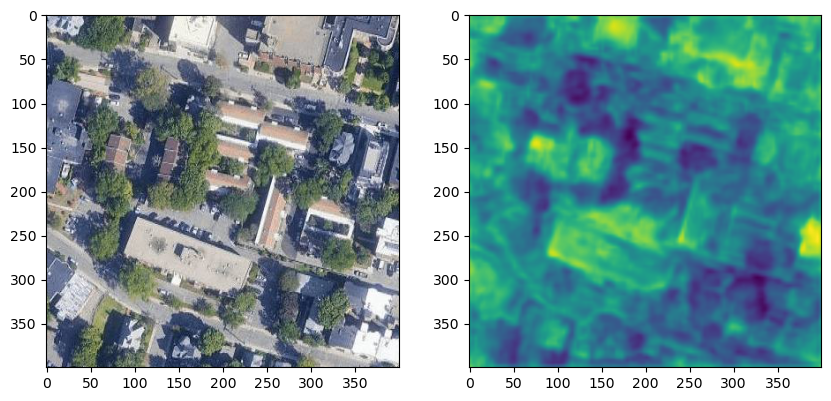

In [5]:
img_tens = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()
out = model(img_tens)

pred = out.detach().squeeze().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(pred)
plt.show()

# Train on single image

In [6]:
# from src.models.unet_pp import UNetPlus

# model = UNetPlus()

In [7]:
import argparse

args = {
    'device': 'cpu',
    'miou_weight': 1.0,
    'bce_weight': 1.0,
    'mse_weight': 1.0,
    'focal_weight': 1.0,
    'vec_weight': 0.1,
    'edge_weight': 0,
    'gaploss_weight': 0,
    'soft_skeleton_iter': 5,
    'alpha': 0.5,
    'smoothing': 1.0,
    'cl_dice_weight': 0,
    'topo_weight': 0,
    'topo_k0': 3,
    'topo_k1': 3,
 }

args = argparse.Namespace(**args)

args

Namespace(device='cpu', miou_weight=1.0, bce_weight=1.0, mse_weight=1.0, focal_weight=1.0, vec_weight=0.1, edge_weight=0, gaploss_weight=0, soft_skeleton_iter=5, alpha=0.5, smoothing=1.0, cl_dice_weight=0, topo_weight=0, topo_k0=3, topo_k1=3)

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

criterion = Criterion(args)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"#params: {n_params / 1e6:.2f} M")

#params: 60.30 M


In [9]:
img_tens = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()
gt_tens = torch.from_numpy(mask).unsqueeze(0).float()
weights_tens = torch.ones_like(gt_tens)
img_tens.shape, gt_tens.shape

(torch.Size([1, 3, 400, 400]), torch.Size([1, 400, 400]))

Training:   0%|                               | 0/50 [00:04<?, ?it/s, loss=1.88]

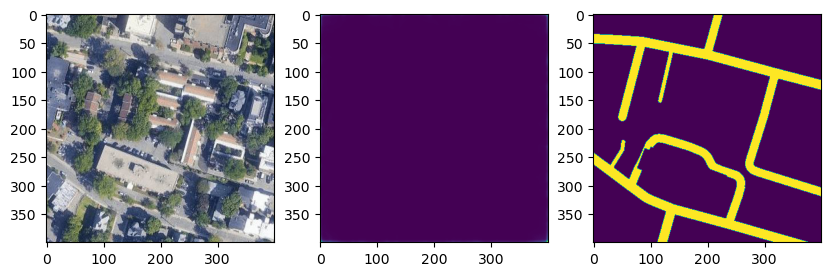

Training:  20%|████▍                 | 10/50 [00:41<02:24,  3.61s/it, loss=1.36]

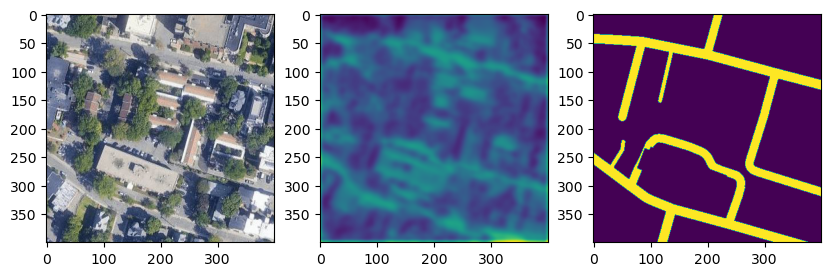

Training:  40%|████████▊             | 20/50 [01:19<01:49,  3.64s/it, loss=1.16]

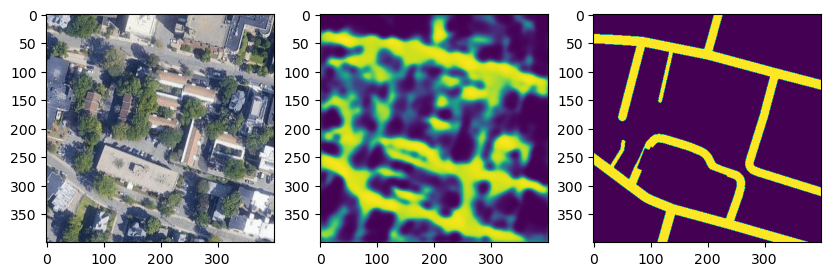

Training:  60%|████████████▌        | 30/50 [01:57<01:13,  3.68s/it, loss=0.911]

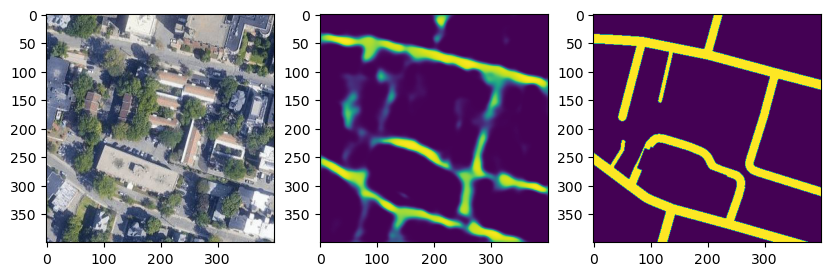

Training:  80%|████████████████▊    | 40/50 [02:35<00:36,  3.69s/it, loss=0.737]

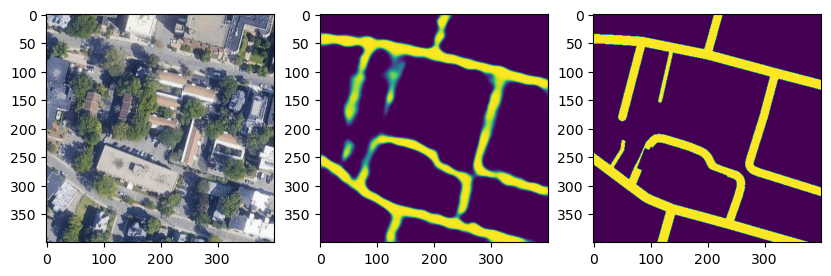

Training: 100%|█████████████████████| 50/50 [03:09<00:00,  3.79s/it, loss=0.686]


In [10]:
from tqdm import tqdm

pbar = tqdm(range(50), desc="Training", ncols=80)

for epoch in pbar:
    optimizer.zero_grad()
    out = model(img_tens).squeeze(1)
    loss = criterion(out, gt_tens, weights_tens)
    loss.backward()
    optimizer.step()
    pbar.set_postfix({"loss": loss.item()})

    if epoch % 10 == 0:
        o = model(img_tens).squeeze(1)

        p = o.squeeze().detach().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        ax[0].imshow(img)
        ax[1].imshow(p)
        ax[2].imshow(mask)
        plt.show()

pbar.close()

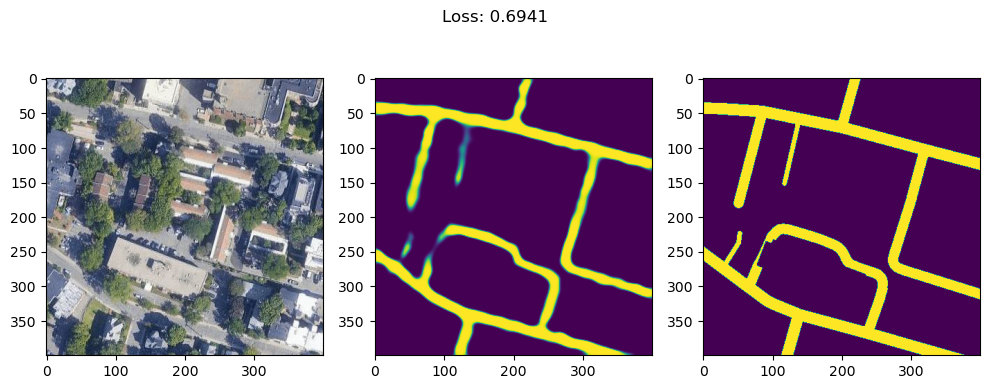

In [11]:
o = model(img_tens)

loss = criterion(o, gt_tens, weights_tens)

p = o.squeeze().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(img)
ax[1].imshow(p)
ax[2].imshow(mask)
fig.suptitle(f"Loss: {loss.item():.4f}")
plt.tight_layout()
plt.show()